In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [4]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import keras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import seaborn as sns

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Alz_multi_balanced/train/',
                                              target_size=(256, 256),
                                              batch_size=32,
                                              class_mode='categorical')
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Alz_multi_balanced/test/',
                                            target_size=(256, 256),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [6]:
train_path='/content/drive/MyDrive/Alz_multi_balanced/train/'
No_images_per_class = []
Class_name = []
for i in os.listdir(train_path):
  train_class = os.listdir(os.path.join(train_path, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Moderate Impairment = 2560 

Number of images in Mild Impairment = 2560 

Number of images in Very Mild Impairment = 2560 

Number of images in No Impairment = 2560 



In [7]:
test_path='/content/drive/MyDrive/Alz_multi_balanced/test/'
No_images_per_class = []
Class_name = []
for i in os.listdir(test_path):
  train_class = os.listdir(os.path.join(test_path, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Very Mild Impairment = 448 

Number of images in No Impairment = 640 

Number of images in Mild Impairment = 179 

Number of images in Moderate Impairment = 12 



In [14]:
from glob import glob
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Alz_multi_balanced/train/*')
print(len(folders))

4


In [9]:
# Define the channel attention mechanism
class ChannelAttention(Layer):
    def __init__(self):
        super(ChannelAttention, self).__init__()

    def build(self, input_shape):
        self.global_avg_pooling = GlobalAveragePooling2D()
        self.dense_1 = Dense(units=input_shape[-1] // 2, activation='relu')
        self.dense_2 = Dense(units=input_shape[-1], activation='sigmoid')
        super(ChannelAttention, self).build(input_shape)

    def call(self, x):
        avg_pool = self.global_avg_pooling(x)
        avg_pool = Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)
        avg_pool = self.dense_1(avg_pool)
        avg_pool = self.dense_2(avg_pool)
        return Multiply()([x, avg_pool])

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(folders), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 128)      

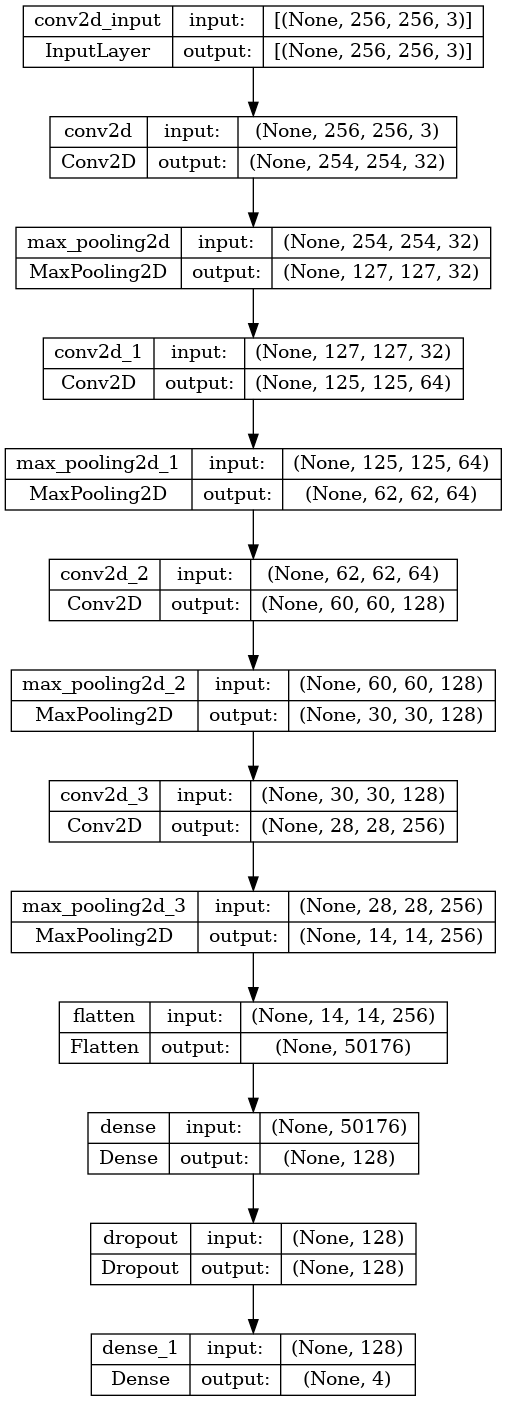

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
filepath1="best_weights.h5"
filepath2="best_model.json"
checkpoint = ModelCheckpoint(filepath1,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

In [18]:
history = model.fit(train_set,
                    steps_per_epoch=train_set.samples//32,
                    epochs=3,
                    validation_data=test_set,
                    validation_steps=test_set.samples//32,
                    callbacks=callbacks_list)

Epoch 1/3
320/320 [==============================] - ETA: 0s - loss: 1.0446 - accuracy: 0.5032 
Epoch 1: val_accuracy improved from -inf to 0.54808, saving model to best_weights.h5
320/320 [==============================] - 4242s 13s/step - loss: 1.0446 - accuracy: 0.5032 - val_loss: 0.9517 - val_accuracy: 0.5481


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/3
320/320 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.7265
Epoch 2: val_accuracy improved from 0.54808 to 0.58173, saving model to best_weights.h5
320/320 [==============================] - 202s 631ms/step - loss: 0.5871 - accuracy: 0.7265 - val_loss: 0.8490 - val_accuracy: 0.5817
Epoch 3/3
320/320 [==============================] - ETA: 0s - loss: 0.5097 - accuracy: 0.7609
Epoch 3: val_accuracy improved from 0.58173 to 0.60737, saving model to best_weights.h5
320/320 [==============================] - 208s 648ms/step - loss: 0.5097 - accuracy: 0.7609 - val_loss: 0.7874 - val_accuracy: 0.6074


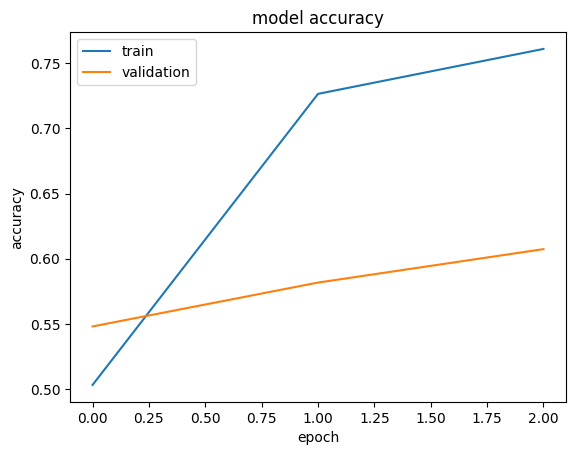

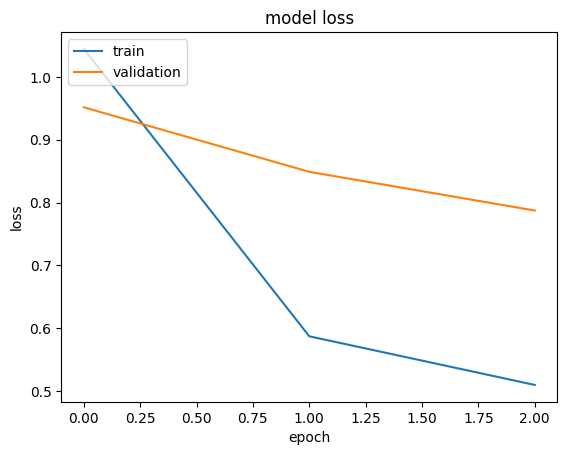

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

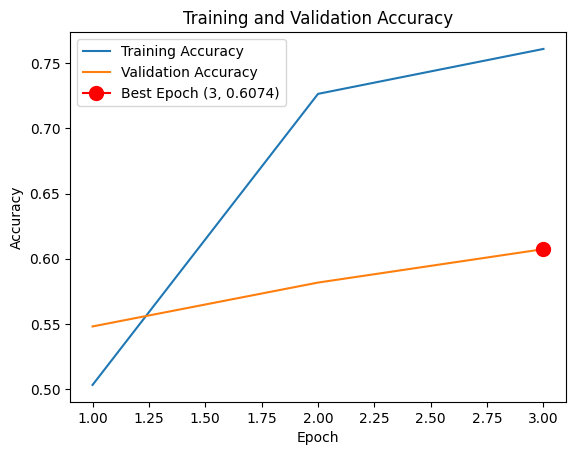

In [20]:
# Extracting the validation accuracy values and finding the epoch with the highest value
val_acc = history.history['val_accuracy']
best_epoch = val_acc.index(max(val_acc)) + 1  # Add 1 to convert index to epoch number

# Plotting the training history
epochs = range(1, len(val_acc) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Highlighting the epoch with the highest validation accuracy
plt.plot(best_epoch, val_acc[best_epoch - 1], marker='o', markersize=10, label=f'Best Epoch ({best_epoch}, {val_acc[best_epoch - 1]:.4f})', color='red')

# Adding plot labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

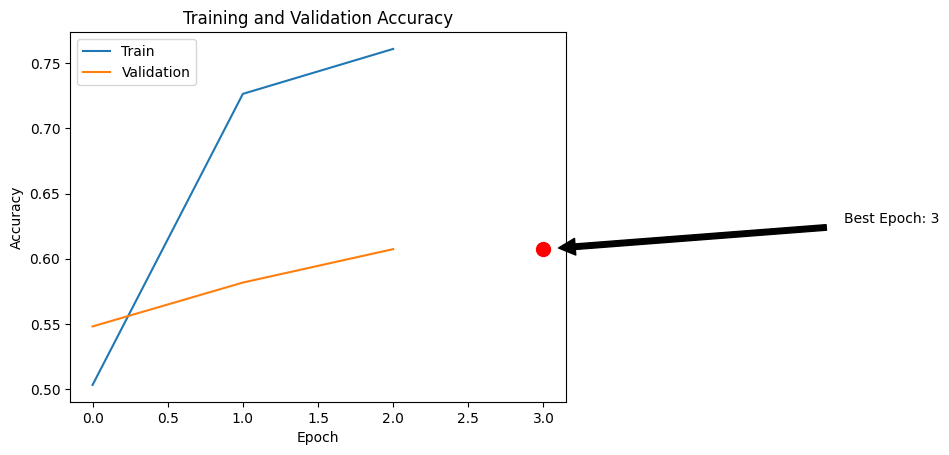

In [21]:
# Extract the training and validation accuracy for each epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Find the epoch with the highest validation accuracy
best_epoch = val_acc.index(max(val_acc)) + 1

# Plot the training and validation accuracy as a function of epoch
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Highlight the epoch with the highest validation accuracy
plt.scatter(best_epoch, val_acc[best_epoch-1], c='red', s=100)
plt.annotate('Best Epoch: ' + str(best_epoch), xy=(best_epoch, val_acc[best_epoch-1]), xytext=(best_epoch+2, val_acc[best_epoch-1]+0.02),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [22]:
from tensorflow.keras.models import load_model

model.save('/content/best_weights.h5')

In [23]:
# Function to generate Grad-CAM heatmap for a given image and class index
def grad_cam(model, img_array, layer_name, class_idx):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.dot(output, weights)

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    return cam

In [25]:
# load model
model = load_model('/content/best_weights.h5')

In [34]:
# Choose the layer name to visualize
layer_name = 'conv2d_7'

In [28]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [31]:
# Choose an image from the test dataset for each class
image_paths = {
    'Class 0': '/content/drive/MyDrive/Alz_multi_balanced/test/No Impairment/1 (21).jpg',
    'Class 1': '/content/drive/MyDrive/Alz_multi_balanced/test/Very Mild Impairment/1 (21).jpg',
    'Class 2': '/content/drive/MyDrive/Alz_multi_balanced/test/Mild Impairment/1 (11).jpg',
    'Class 3': '/content/drive/MyDrive/Alz_multi_balanced/test/Moderate Impairment/16 (2).jpg'
}

In [79]:
image_path = {
    'Class 0': '/content/drive/MyDrive/Alz_multi_balanced/test/No Impairment/1 (28).jpg',
    'Class 1': '/content/drive/MyDrive/Alz_multi_balanced/test/Very Mild Impairment/1 (41).jpg',
    'Class 2': '/content/drive/MyDrive/Alz_multi_balanced/test/Mild Impairment/1 (2).jpg',
    'Class 3': '/content/drive/MyDrive/Alz_multi_balanced/test/Moderate Impairment/22 (2).jpg'
}

In [85]:
image_pat= {
    'Class 0': '/content/drive/MyDrive/Alz_multi_balanced/test/No Impairment/1 (33).jpg',
    'Class 1': '/content/drive/MyDrive/Alz_multi_balanced/test/Very Mild Impairment/1 (41).jpg',
    'Class 2': '/content/drive/MyDrive/Alz_multi_balanced/test/Mild Impairment/1 (2).jpg',
    'Class 3': '/content/drive/MyDrive/Alz_multi_balanced/test/Moderate Impairment/22 (2).jpg'
}

1/1 [==============================] - 0s 31ms/step


<ipython-input-23-a52ece41cb0e>:17: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
<ipython-input-46-788cdf4fbf82>:21: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Change here


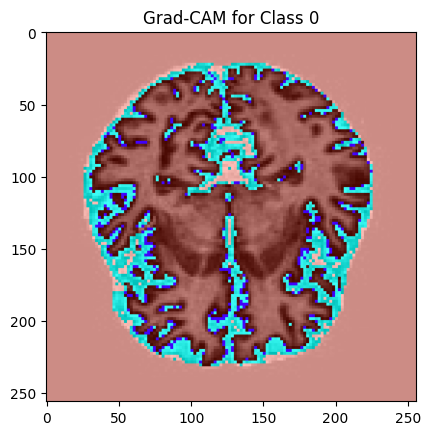

1/1 [==============================] - 0s 47ms/step


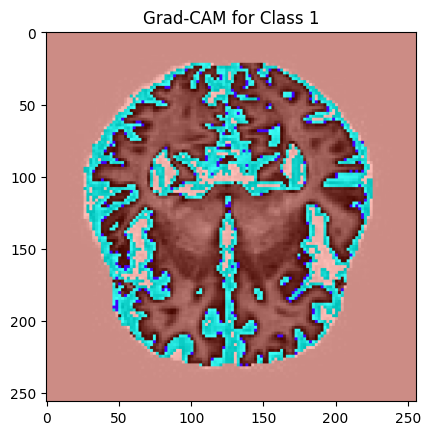

1/1 [==============================] - 0s 94ms/step


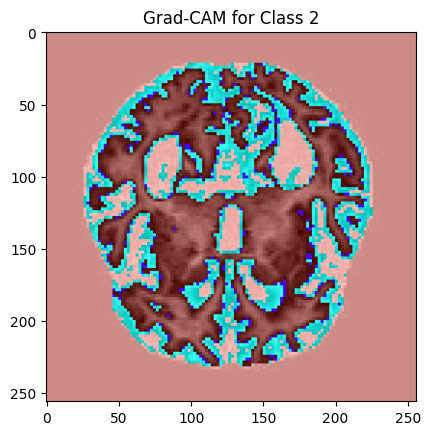

1/1 [==============================] - 0s 92ms/step


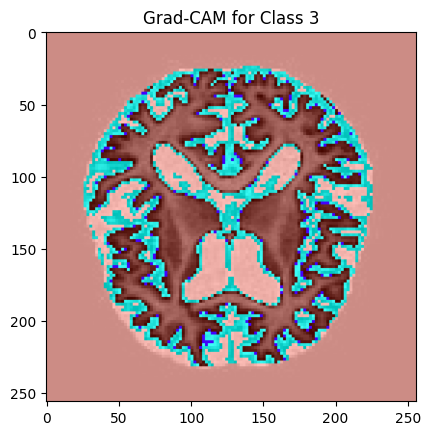

In [46]:
import cv2

# Generate Grad-CAM for each class
for class_name, img_path in image_paths.items():
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the predicted class index
    preds = model.predict(img_array)
    class_idx = np.argmax(preds)

    # Generate Grad-CAM heatmap
    cam = grad_cam(model, img_array, layer_name, class_idx)

    # Resize Grad-CAM heatmap to match the original image size
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))

    # Apply colormap to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Change here

    # Superimpose heatmap on original image
    superimposed_img = heatmap * 0.4 + img_array[0]

    # Plot Grad-CAM
    plt.figure()
    plt.title(f'Grad-CAM for {class_name}')
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.show()


1/1 [==============================] - 0s 19ms/step


<ipython-input-55-2ec8c682ff83>:40: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
<ipython-input-86-81c2cc6e60c5>:21: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Change here


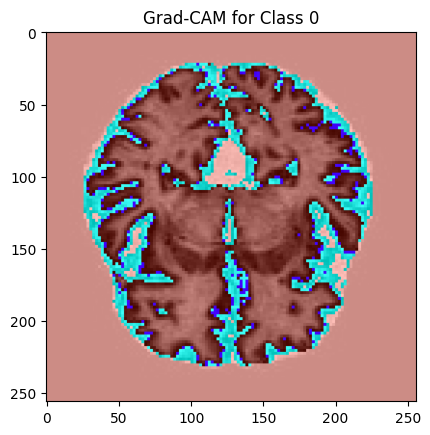

1/1 [==============================] - 0s 19ms/step


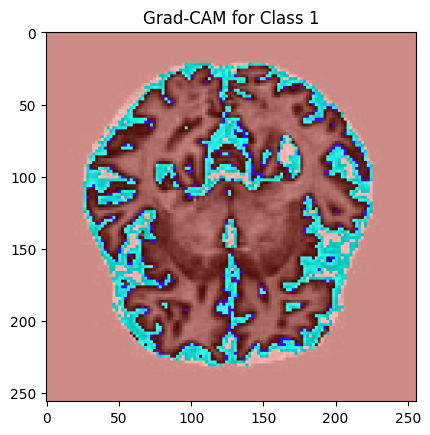

1/1 [==============================] - 0s 26ms/step


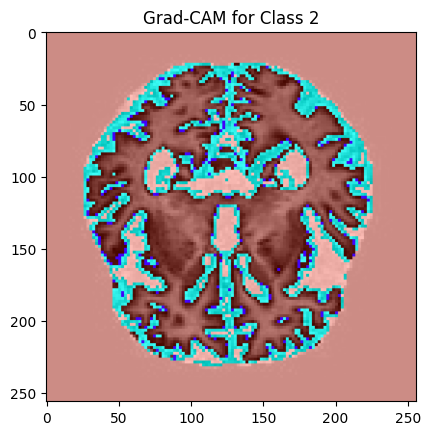

1/1 [==============================] - 0s 18ms/step


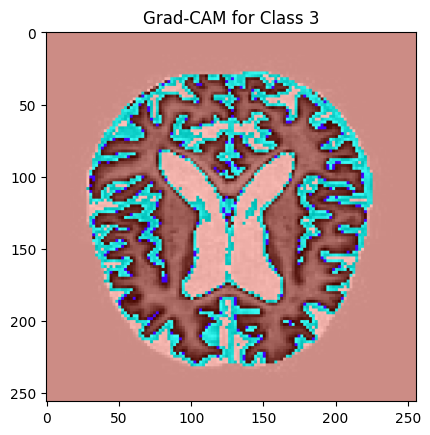

In [86]:
import cv2

# Generate Grad-CAM for each class
for class_name, img_path in image_pat.items():
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the predicted class index
    preds = model.predict(img_array)
    class_idx = np.argmax(preds)

    # Generate Grad-CAM heatmap
    cam = grad_cam(model, img_array, layer_name, class_idx)

    # Resize Grad-CAM heatmap to match the original image size
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))

    # Apply colormap to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Change here

    # Superimpose heatmap on original image
    superimposed_img = heatmap * 0.4 + img_array[0]

    # Plot Grad-CAM
    plt.figure()
    plt.title(f'Grad-CAM for {class_name}')
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.show()

1/1 [==============================] - 0s 19ms/step


<ipython-input-55-2ec8c682ff83>:40: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
<ipython-input-80-70155e016f29>:21: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Change here


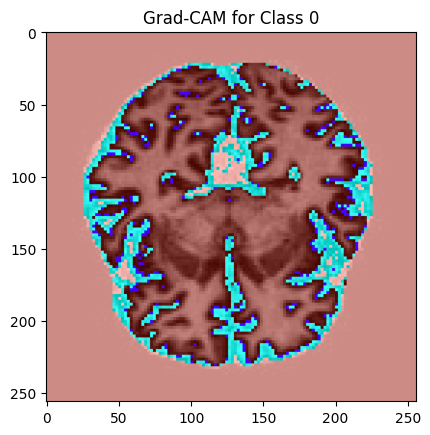

1/1 [==============================] - 0s 18ms/step


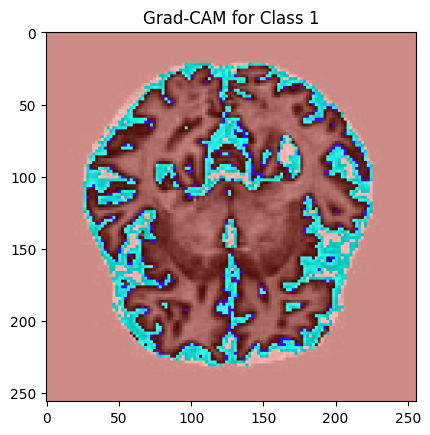

1/1 [==============================] - 0s 18ms/step


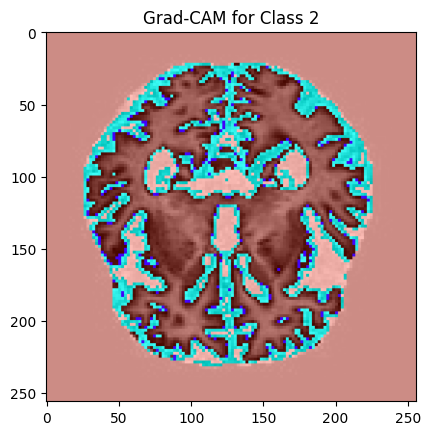

1/1 [==============================] - 0s 21ms/step


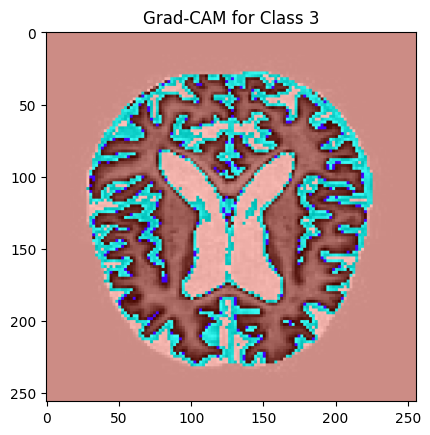

In [80]:
import cv2

# Generate Grad-CAM for each class
for class_name, img_path in image_path.items():
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the predicted class index
    preds = model.predict(img_array)
    class_idx = np.argmax(preds)

    # Generate Grad-CAM heatmap
    cam = grad_cam(model, img_array, layer_name, class_idx)

    # Resize Grad-CAM heatmap to match the original image size
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))

    # Apply colormap to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Change here

    # Superimpose heatmap on original image
    superimposed_img = heatmap * 0.4 + img_array[0]

    # Plot Grad-CAM
    plt.figure()
    plt.title(f'Grad-CAM for {class_name}')
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.show()

1/1 [==============================] - 0s 288ms/step


<ipython-input-55-2ec8c682ff83>:40: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
<ipython-input-74-96d891cfa946>:22: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)


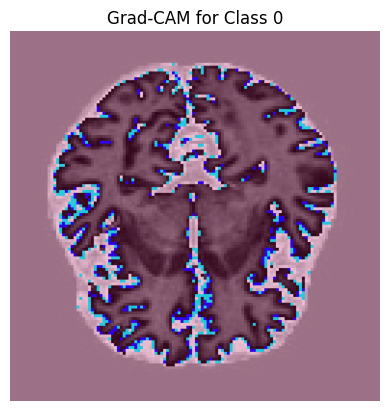

1/1 [==============================] - 0s 78ms/step


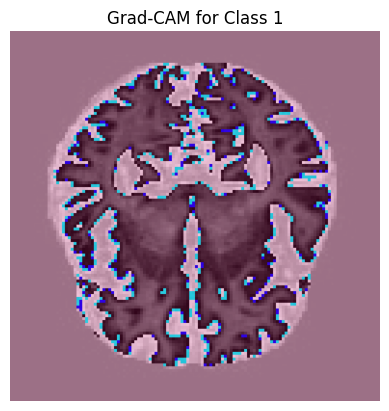

1/1 [==============================] - 0s 73ms/step


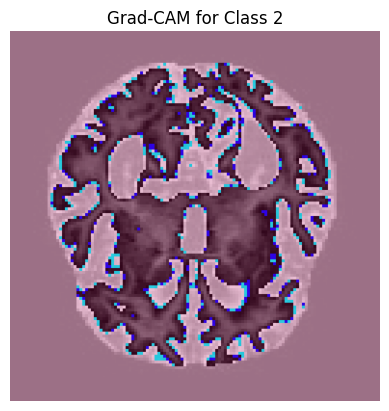

1/1 [==============================] - 0s 29ms/step


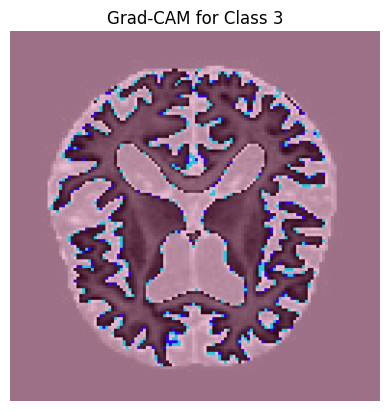

In [74]:
import cv2

# Generate Grad-CAM for each class
for class_name, img_path in image_paths.items():
    # Load and preprocess the query image
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the predicted class index
    preds = model.predict(img_array)
    class_idx = np.argmax(preds)

    # Generate Grad-CAM heatmap
    cam = grad_cam(model, img_array, layer_name, class_idx)

    # Resize Grad-CAM heatmap to match the original image size
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))

    # Apply colormap to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)

    # Blend heatmap with the original image
    superimposed_img = cv2.addWeighted(img_array[0].astype(np.uint8), 0.8, heatmap, 0.4, 0)

    # Plot Grad-CAM
    plt.figure()
    plt.title(f'Grad-CAM for {class_name}')
    plt.imshow(superimposed_img)
    plt.axis('off')  # Remove axis
    plt.show()


1/1 [==============================] - 0s 40ms/step


<ipython-input-55-2ec8c682ff83>:40: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
<ipython-input-81-e29ea1574bda>:22: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)


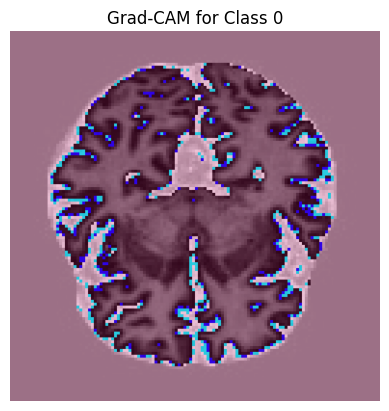

1/1 [==============================] - 0s 29ms/step


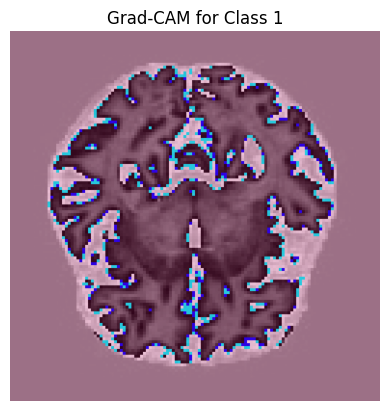

1/1 [==============================] - 0s 28ms/step


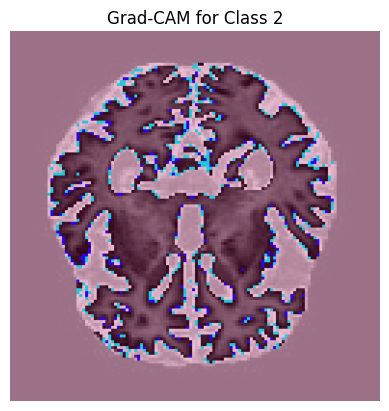

1/1 [==============================] - 0s 61ms/step


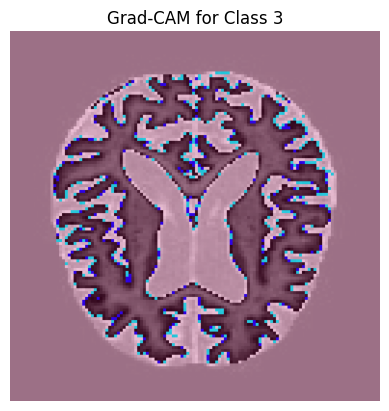

In [81]:
import cv2

# Generate Grad-CAM for each class
for class_name, img_path in image_path.items():
    # Load and preprocess the query image
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the predicted class index
    preds = model.predict(img_array)
    class_idx = np.argmax(preds)

    # Generate Grad-CAM heatmap
    cam = grad_cam(model, img_array, layer_name, class_idx)

    # Resize Grad-CAM heatmap to match the original image size
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))

    # Apply colormap to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)

    # Blend heatmap with the original image
    superimposed_img = cv2.addWeighted(img_array[0].astype(np.uint8), 0.8, heatmap, 0.4, 0)

    # Plot Grad-CAM
    plt.figure()
    plt.title(f'Grad-CAM for {class_name}')
    plt.imshow(superimposed_img)
    plt.axis('off')  # Remove axis
    plt.show()

1/1 [==============================] - 0s 31ms/step


<ipython-input-55-2ec8c682ff83>:40: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
<ipython-input-82-668a78c6da85>:22: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_HOT)


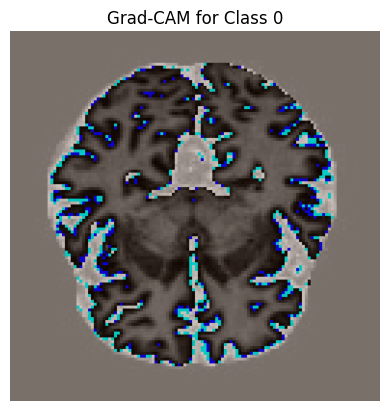

1/1 [==============================] - 0s 27ms/step


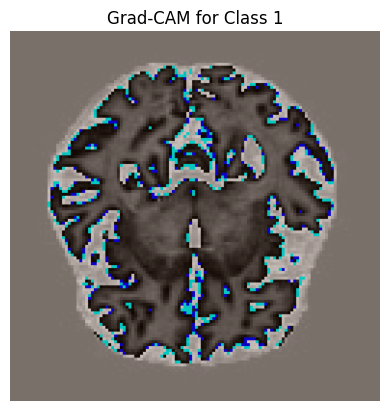

1/1 [==============================] - 0s 29ms/step


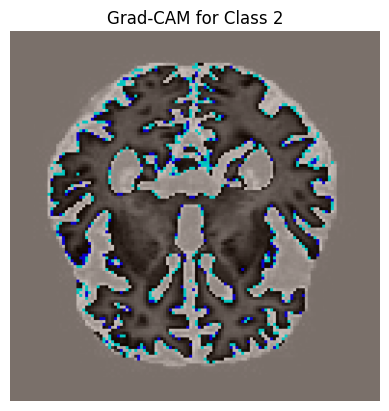

1/1 [==============================] - 0s 26ms/step


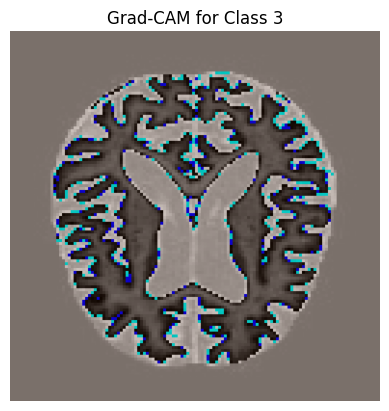

In [82]:
import cv2

# Generate Grad-CAM for each class
for class_name, img_path in image_path.items():
    # Load and preprocess the query image
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the predicted class index
    preds = model.predict(img_array)
    class_idx = np.argmax(preds)

    # Generate Grad-CAM heatmap
    cam = grad_cam(model, img_array, layer_name, class_idx)

    # Resize Grad-CAM heatmap to match the original image size
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))

    # Apply colormap to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_HOT)

    # Blend heatmap with the original image
    superimposed_img = cv2.addWeighted(img_array[0].astype(np.uint8), 0.8, heatmap, 0.4, 0)

    # Plot Grad-CAM
    plt.figure()
    plt.title(f'Grad-CAM for {class_name}')
    plt.imshow(superimposed_img)
    plt.axis('off')  # Remove axis
    plt.show()

In [40]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_set, steps = test_set.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

39/39 [==============================] - 6s 155ms/step - loss: 0.7874 - accuracy: 0.6074
Accuracy Test : 0.6073718070983887


In [41]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_set.classes, y_pred)
cr = classification_report(test_set.classes, y_pred, target_names=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])

40/40 [==============================] - 7s 161ms/step


In [42]:
print(cm)
print(cr)

[[ 52   0  16 111]
 [  0   4   3   5]
 [ 21   1 461 157]
 [ 32   0 147 269]]
                      precision    recall  f1-score   support

     Mild Impairment       0.50      0.29      0.37       179
 Moderate Impairment       0.80      0.33      0.47        12
       No Impairment       0.74      0.72      0.73       640
Very Mild Impairment       0.50      0.60      0.54       448

            accuracy                           0.61      1279
           macro avg       0.63      0.49      0.53      1279
        weighted avg       0.62      0.61      0.61      1279



In [43]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_pred,test_set.classes)))
print('Cohen Kappa Score: {:.2f}'.format(cohen_kappa_score(y_pred,test_set.classes)))
print('Recall: {:.2f}'.format(recall_score(test_set.classes, y_pred, average='micro')))
print('F1-score: {:.2f}'.format(f1_score(test_set.classes, y_pred, average='micro')))
print('Precision: {:.2f}'.format(precision_score(test_set.classes, y_pred, average='macro')))


Accuracy: 0.61

Cohen Kappa Score: 0.35
Recall: 0.61
F1-score: 0.61
Precision: 0.63


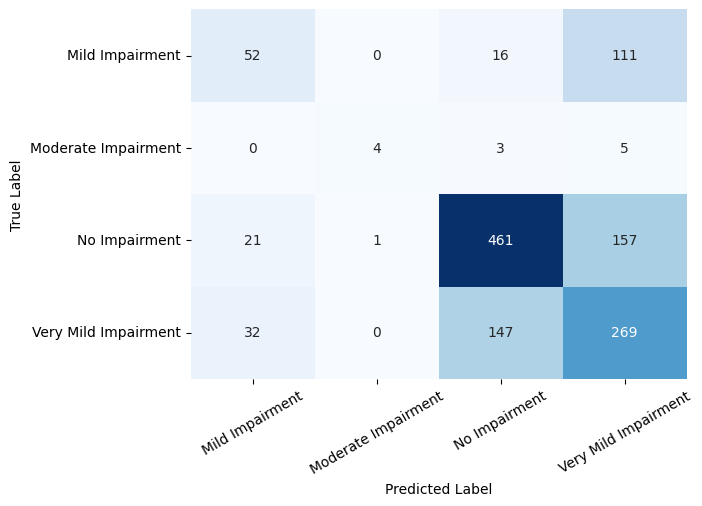

In [44]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], yticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], cbar=False)
plt.xticks(rotation=30)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()